In [19]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


/tmp/ipython-input-1135453433.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2026-10-27")
[*********************100%***********************]  1 of 1 completed


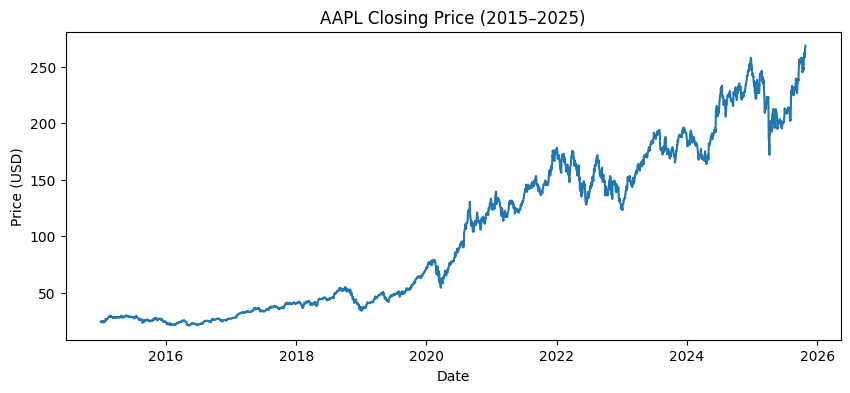

In [7]:
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2026-10-27")
data = data[['Close']]

plt.figure(figsize=(10,4))
plt.plot(data['Close'])
plt.title(f"{ticker} Closing Price (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

seq_length = 60  # 60 days lookback
X, y = [], []
for i in range(seq_length, len(scaled_data)):
    X.append(scaled_data[i - seq_length:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [9]:
def build_rnn_model():
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model():
    model = Sequential([
        GRU(50, activation='tanh', input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [12]:
print("Training Simple RNN...")
rnn_model = build_rnn_model()
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_data=(X_test, y_test), verbose=0)

print("Training LSTM...")
lstm_model = build_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_data=(X_test, y_test), verbose=0)

print("Training GRU...")
gru_model = build_gru_model()
gru_history = gru_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_data=(X_test, y_test), verbose=0)

Training Simple RNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM...
Training GRU...


In [13]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    print(f"\n{name} Evaluation Metrics:")
    print(f"  MSE  : {mse:.6f}")
    print(f"  RMSE : {rmse:.6f}")
    print(f"  MAE  : {mae:.6f}")
    print(f"  R²   : {r2:.6f}")
    return y_pred_inv, y_test_inv

y_pred_rnn, y_true = evaluate_model(rnn_model, X_test, y_test, "Simple RNN")
y_pred_lstm, _ = evaluate_model(lstm_model, X_test, y_test, "LSTM")
y_pred_gru, _ = evaluate_model(gru_model, X_test, y_test, "GRU")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Simple RNN Evaluation Metrics:
  MSE  : 28.219279
  RMSE : 5.312182
  MAE  : 4.276024
  R²   : 0.957032
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

LSTM Evaluation Metrics:
  MSE  : 27.332942
  RMSE : 5.228092
  MAE  : 3.916530
  R²   : 0.958382
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

GRU Evaluation Metrics:
  MSE  : 20.143537
  RMSE : 4.488155
  MAE  : 3.427050
  R²   : 0.969328


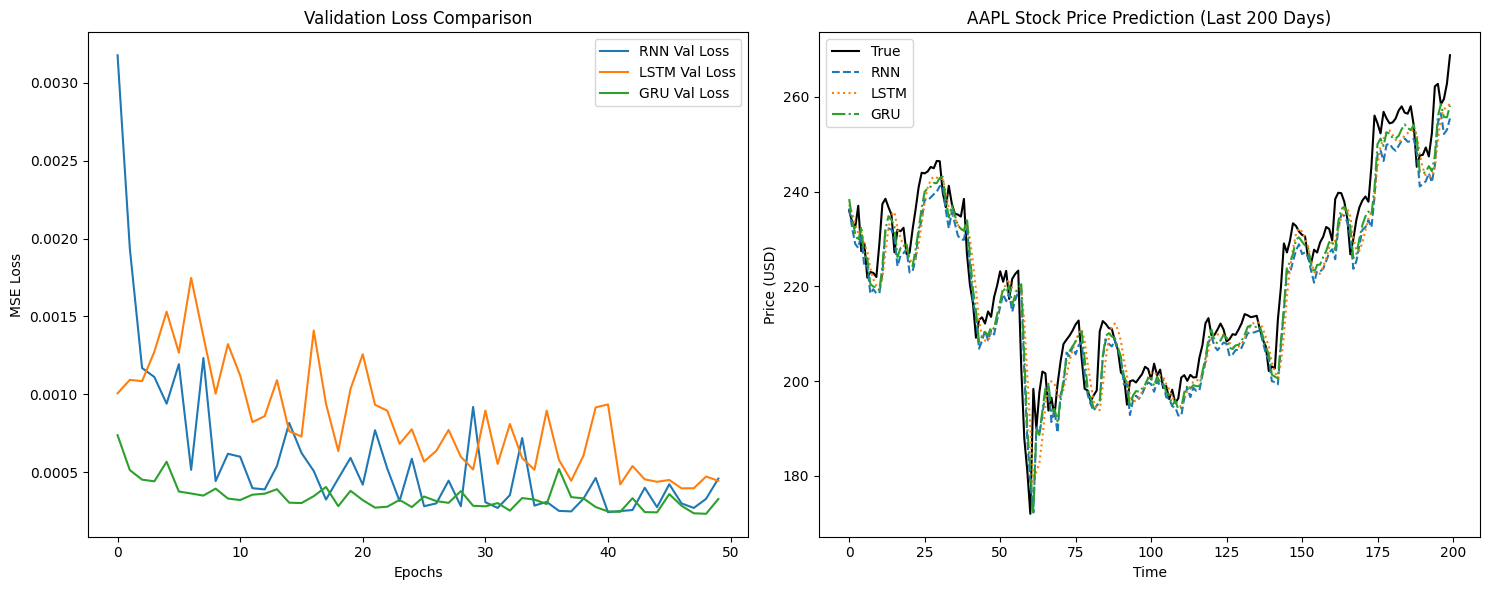

In [14]:
plt.figure(figsize=(15,6))

# Validation loss comparison
plt.subplot(1,2,1)
plt.plot(rnn_history.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Prediction comparison
plt.subplot(1,2,2)
plt.plot(y_true[-200:], label='True', color='black')
plt.plot(y_pred_rnn[-200:], label='RNN', linestyle='dashed')
plt.plot(y_pred_lstm[-200:], label='LSTM', linestyle='dotted')
plt.plot(y_pred_gru[-200:], label='GRU', linestyle='dashdot')
plt.title(f"{ticker} Stock Price Prediction (Last 200 Days)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# ---------------------- FUTURE FORECAST FUNCTION ----------------------
def predict_future_date(target_date_str, model, model_name):
    """
    Predicts stock price for a future date (beyond dataset range) using the specified model.
    """
    target_date = datetime.strptime(target_date_str, "%Y-%m-%d")
    last_known_date = data.index[-1].to_pydatetime()
    last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)

    current_date = last_known_date
    future_scaled = []
    while current_date < target_date:
        pred_scaled = model.predict(last_sequence, verbose=0)
        future_scaled.append(pred_scaled[0, 0])
        last_sequence = np.append(last_sequence[:, 1:, :], [pred_scaled], axis=1)
        current_date += timedelta(days=1)

    future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1))
    predicted_price = future_prices[-1, 0]

    print(f"\n🔮 {model_name} Prediction for {ticker} on {target_date.date()}: ${predicted_price:.2f}")

    # Plot forecast
    plt.figure(figsize=(10,4))
    plt.plot(data.index[-200:], data['Close'].tail(200), label="Historical")
    future_dates = pd.date_range(start=last_known_date + timedelta(days=1), periods=len(future_prices))
    plt.plot(future_dates, future_prices, label=f"{model_name} Predicted", linestyle="dashed")
    plt.title(f"{ticker} {model_name} Stock Price Prediction until {target_date.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()


🔮 LSTM Prediction for AAPL on 2026-10-27: $151.38


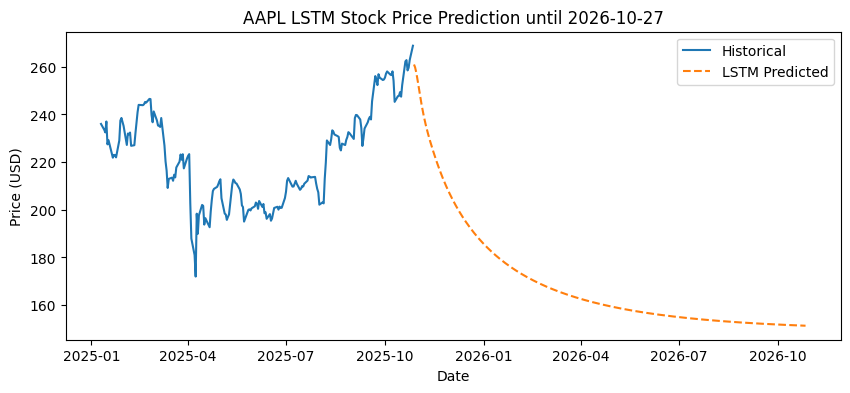


🔮 RNN Prediction for AAPL on 2026-10-27: $-1.34


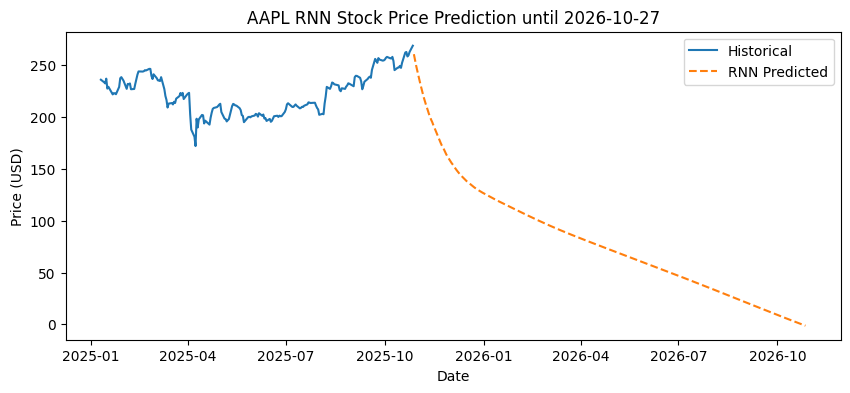


🔮 GRU Prediction for AAPL on 2026-10-27: $77.40


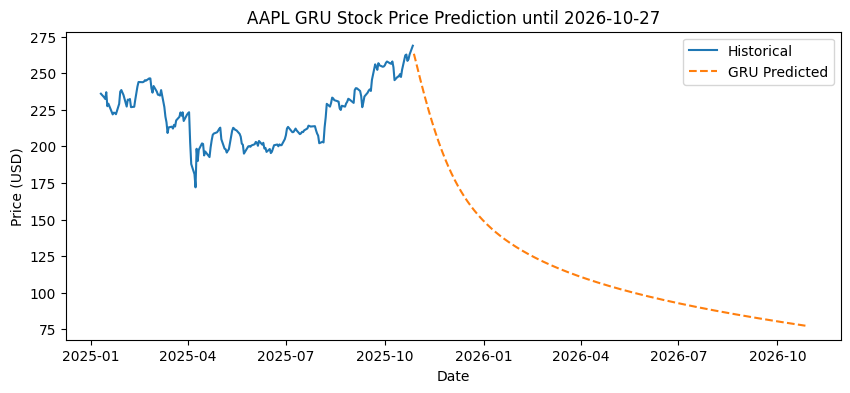

In [22]:
predict_future_date("2026-10-27", lstm_model, "LSTM")
predict_future_date("2026-10-27", rnn_model, "RNN")
predict_future_date("2026-10-27", gru_model, "GRU")